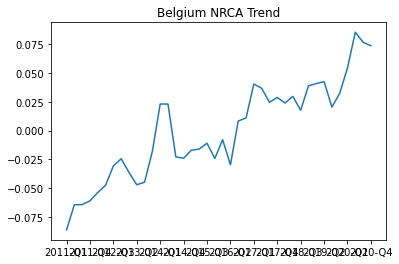

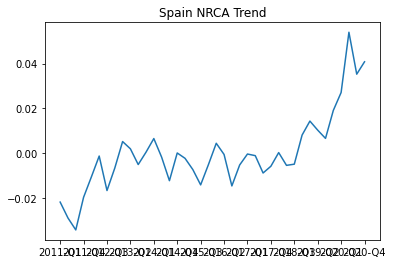

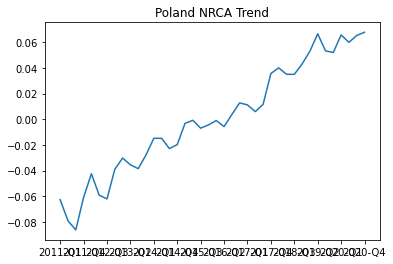

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gmean

#Setting the path to the parent directory of RR classes
path = r"C:/Users/User/retake/RRcourse2024"
os.chdir(path)

# Loading O*NET task data
task_data = pd.read_csv("Data\\onet_tasks.csv")

# Loading employment data from Eurostat for different ISCO-08 occupation categories
isco_sheets = ["ISCO1", "ISCO2", "ISCO3", "ISCO4", "ISCO5", "ISCO6", "ISCO7", "ISCO8", "ISCO9"]
isco_data = [pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name=sheet) for sheet in isco_sheets]

# Calculating total employment for each country
countries = ["Belgium", "Spain", "Poland"]
totals = {country: sum(df[country] for df in isco_data) for country in countries}

# Adding ISCO category column to each dataframe
for i, df in enumerate(isco_data, start=1):
    df['ISCO'] = i

# Combining all ISCO data into one dataframe
all_data = pd.concat(isco_data, ignore_index=True)

# Adding total employment columns and calculate occupation shares
for country in countries:
    all_data[f'total_{country}'] = pd.concat([totals[country]] * len(isco_sheets), ignore_index=True)
    all_data[f'share_{country}'] = all_data[country] / all_data[f'total_{country}']

# Extracting the first digit of ISCO code and aggregating the data
task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[0].astype(int)
aggdata = task_data.groupby("isco08_1dig").mean().drop(columns=["isco08"])

# Merging task data with employment data
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')

# Standardizing task values for each country
tasks = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]

for task in tasks:
    for country in countries:
        temp_mean = np.average(combined[task], weights=combined[f'share_{country}'])
        temp_sd = np.sqrt(np.average((combined[task] - temp_mean) ** 2, weights=combined[f'share_{country}']))
        combined[f'std_{country}_{task}'] = (combined[task] - temp_mean) / temp_sd

# Calculating NRCA intensity
for country in countries:
    combined[f'{country}_NRCA'] = sum(combined[f'std_{country}_{task}'] for task in tasks)
    temp_mean = np.average(combined[f'{country}_NRCA'], weights=combined[f'share_{country}'])
    temp_sd = np.sqrt(np.average((combined[f'{country}_NRCA'] - temp_mean) ** 2, weights=combined[f'share_{country}']))
    combined[f'std_{country}_NRCA'] = (combined[f'{country}_NRCA'] - temp_mean) / temp_sd

# Calculate country-level NRCA mean over time
agg_data = {}
for country in countries:
    combined[f'multip_{country}_NRCA'] = combined[f'std_{country}_NRCA'] * combined[f'share_{country}']
    agg_data[country] = combined.groupby("TIME")[f'multip_{country}_NRCA'].sum().reset_index()

# Plot NRCA trends over time
for country in countries:
    plt.plot(agg_data[country]["TIME"], agg_data[country][f'multip_{country}_NRCA'])
    plt.xticks(range(0, len(agg_data[country]), 3), agg_data[country]["TIME"][::3])
    plt.title(f'{country} NRCA Trend')
    plt.show()

# The code can be easily extended to other countries and task categories.
